### 实战Kaggle比赛：房价预测

#### 读取数据集

In [1]:
# 如果没有安装pandas，反注释下面一行
# !pip install pandas

%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, data as gdata, nn
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('../data_house_prices_advanced_regression_techniques/train.csv')
test_data = pd.read_csv('../data_house_prices_advanced_regression_techniques/test.csv')

In [3]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

#### 查看前4个样本的前4个特征、后两个特征和标签（SalePrice）

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


#### 第一个特征Id会帮助模型记住每个训练样本，难以推广到预测样本，不使用它来训练模型。将所有的训练数据和测试数据的79个特征按样本连接。

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [6]:
a = all_features.dtypes[all_features.dtypes != 'object'].index
a

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

#### 数据预处理

##### 对连续数值的特征做标准化(standardization)：将特征的每个值先减去均值，然后除以标准差。对于缺失的特征值，替换成改特征值的均值。

In [7]:
numeric_features_indices = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features_indices] = all_features[numeric_features_indices].apply(
    lambda x: (x-x.mean())/x.std())
# 标准化之后，每个特征的均值变为0，可以直接用0替换缺失值
all_features[numeric_features_indices] = all_features[numeric_features_indices].fillna(0)

##### 将离散数值转换成指示特征。假设特征MSZoning里面有两个不相同的离散值RL和RM，这一步转化将去掉MSZoning特征，并加上两个特征MSZoning_RL和MSZoning_RM，其值为0或1。

In [8]:
# dummy_na=True将缺失值也当作合法的特征值，并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

##### 通过values属性将数据转换为Numpy格式，然后转换成NDArray方便后面的训练。

In [9]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
train_labels = nd.array(train_data['SalePrice'].values).reshape((-1, 1))
test_features = nd.array(all_features[n_train:].values)

#### 训练模型。使用基本的线性回归模型和平方损失函数来训练模型。

In [10]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [11]:
loss = gloss.L2Loss()

#### 定义比赛用来评价模型的对数平方根误差。log_rmse = (1/n*(log(yi)-log(yi_hat))^2)^(1/2), i=1,2,...,n

In [12]:
def log_rmse(net, features, labels):
    # 将小于1的值设置成1，使得取对数时数值更加稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2*loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

#### 定义训练函数。使用Adam优化算法，相比于小批量随机梯度下降，它对学习率不是那么敏感。

In [13]:
def train(net, train_features, train_labels, test_features, test_labels, 
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':learning_rate, 'wd':weight_decay})
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### k折交叉验证。用来选择模型设计并调节超参数。

In [14]:
def get_k_fold_data(k, i, X, y):
    """返回第i折交叉验证时所需要的训练和验证数据"""
    assert k>1
    fold_size = X.shape[0]//k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j==i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

##### 在k折交叉验证中，训练k次并返回训练和验证的平均误差

In [15]:
def k_fold(k, X_train, y_train, num_epochs,
          learning_rate, weight_decay, batch_size):
    train_ls_sum, valid_ls_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_ls_sum += train_ls[-1]
        valid_ls_sum += valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs+1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
             % (i, train_ls[-1], valid_ls[-1]))
    return train_ls_sum/k, valid_ls_sum/k

#### 模型选择。计算交叉验证误差，可以通过改变超参数尽可能减小平均测试误差。

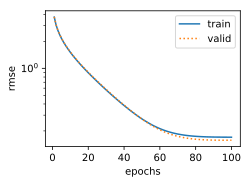

fold 0, train rmse 0.169995, valid rmse 0.157235
fold 1, train rmse 0.162004, valid rmse 0.190149
fold 2, train rmse 0.163629, valid rmse 0.167995
fold 3, train rmse 0.167918, valid rmse 0.154702
fold 4, train rmse 0.162785, valid rmse 0.182920
5-fold validation: avg train rmse 0.165266, avg valid rmse 0.170600


In [16]:
k, num_epochs, batch_size, learning_rate, weight_decay = 5, 100, 64, 5, 0
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, learning_rate, weight_decay, batch_size)

print('%d-fold validation: avg train rmse %f, avg valid rmse %f'
     % (k, train_l, valid_l))

#### 预测并在Kaggle提交结果。在预测之前，使用完整的训练数据集重新训练模型。

In [17]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                       num_epochs, lr ,weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'ecpochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat((test_data['Id'], test_data['SalePrice']), axis=1)
    submission.to_csv('submission1.csv')

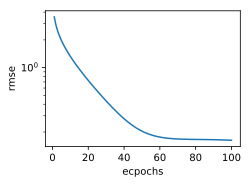

train rmse 0.162631


In [18]:
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, learning_rate, weight_decay, batch_size)